# Introduction

Neural networks are vulnerable to adversarial examples. Adversarial examples alter input data that cause mistakes in models. These alternations must be imperceivable to humans. In the area of Natural Language Processing(NLP),  there exist only a few adversarial attacks. This might be due to the difficulty that words in sentences are discrete tokens, while images are continuous. It is much easier for a human to determine a perturbed sentence while minor changes to image pixels still yield a meaningful image for human eyes.

In this project we will focus on a single adversarial attack, as well as two potential defense methods.

# Motivation

The existence of adversarial examples for any task raises concerns about the safe use of neural networks. In NLP tasks such as document classification, named entity recognition, spam filtering, fake news detection, sentiment analysis, etc... adversarial examples that cause incorrect predictions could result in a variety of issues. For example in a form of governmental document classification if a form is misclassified and filed it could have potential security issues. 

# Approach

In this project we focus on Generating Natural Language Adversarial Examples through Probability Weighted Word Saliency. Their work provides an adversarial attack that insures lexical correctness with few grammatical errors and little semantic shifting.

The work introduces a new synonym replacement method: Probability Weighted Word Saliency (PWWS). PWWS considers the word saliency as well as the classification probability. The change value of the classification probability is used to measure the attack effect of the proposed substitute word, while word saliency shows how well the original word affects the classification.  The change value of the classification probability weighted by word saliency determines the final substitute word and replacement order.

In order to defend against this attack we will explore two methods: applying spectral normalization, and directly increase the inter-class variance for synonym word vectors as we want to study the link between cosine similarity and adversarial robustness.

## Attack

### Probability Weighted Word Saliency (PWWS)

A high quality perturbation that is imperceptible to humans needs to satisfy lexical, grammatical, and semantic constraints. Lexical constraints prevent common misspellings while the semantic constraint insures the message of the text remains the same [4]. 

Given a sentence which is represented as sequence of words:

$x = w_1 w_2 ... w_i ... w_n$

PWWS attempts to replace each $w_i$ with $w_{i}^{'}$

$x^{'} = w_1 w_2 ... w_{i}^{'} ... w_n$

Given the true label: $y_{true}$ PWWS evaluates each replacement via:

$P(y_{true}|x) − P(y_{true}|x^{'})$

Whichever $w_{i}^{'}$ maximizes this difference, is picked to replacemen that word. PWWS evaluates for ALL words in a sentence, and picks the largest $w_{i}^{'}$ for EACH word.  The words are replaced until PWWS either finds an adversarial example, or all words have been replaced and no adversary has been found [4]. More details on this are discussed below.

#### Synonym Classification Probability

To meet the above constraints, words are replaced with  synonyms  and  named entities (NEs) with similar NEs. Synonyms for each word are found in WordNet. NE's are entities that have a specific meaning in the sample text, such as a person’s name, a location, an organization, or a proper noun. To replace an NE, a subset of NE's based on their occurance within classes are created (i.e Christopher Nolan is a person related to a "Good" sentiment). Only related NE's within the same class of NE, as well as from the same label for the input are acceptable synonym replacements. With the synonym subsets created, each word is replaced with it synonym, the input is run through the model, and the substitute word that causes the most significant change in the classification probability after replacement is choosen [4]. 

#### Word Saliency

Word saliency refers to the degree of change in the output probability of the classifier if a word is set to unknown (out of vocabulary). Similar to synonym classification probability, a word is replaced with the unknown token, and the difference in classification probability is recorded. I.e in this case we still evaluate $P(y_{true}|x) − P(y_{true}|x^{'})$ BUT $w_{i}^{'} = \text{<UNK>}$ for all substitutions [4]. 

#### PWWS

The two scores (difference in classification) for each word, synonym pair are multiplied, and sorted. The best candidate for each word is choosen and the replacement order is determined via the highest scores [4].

## Defense

### Spectral Norm

For adversarial defense, we want to first examine the use of spectral normalization for word-embedding model. Spectral normalization is a method that ensures the largest singular value for SVD of each network weight layer is 1 [3]. In this way, the model is very smooth (satisfies the l1-lipschitz constraint) and making small changes to the input will not result in large changes in the final output. As the PWWS attack attempts to make small changes that retain the semantic content of the text, sastify lexical properties, and do not introduce grammatical errors, we belive this method may be an effective defense.

### Maximizing Word Embedding Dissimilarity 

Our hypothesis is that during an attack, synonyms close to semantically different words are found using PWWS i.e the synonym the furthest away from the candidate word is chosen. Considering synonyms are likely with a degree range of cosine similarity, if we were to maximize the word embedding dissimilarity, we could "push" these synonyms out of this range and make them unviable candidates. By doing this we hope that PWWS will only select extremely similar words, and thus fail to fool the model, or ridiculous words in which a human reader could tell the input has been tampered with.

We explicitly formulate the metric using Hamming distance. It can be shown that the Hamming distance between embeddings hash codes and their inner product is [5]:

$dist_H(w_i, w_j) = \frac{1}{2}(L - \frac{|sign(w_i) (sign(w_j))^T|}{||sign(w_i) (sign(w_j))^T||^2_2})$

Where the minimum hamming distance is thus:

$d_{min}(Doc) = min(dist_H(x,y): x, y \in Doc, x \ne y)$

Why the sign? Hamming distance is reservered for embeddings with a DISCRETE amount of states per dimension. In this work we explore using 2 states, i.e binary states, +1 and -1. This way we allow our embeddings to be continuous, while still partly constrainting the embeddings to be in the hamming space.

Why the hamming distance? Simply, it provides a nice theoretical guarantee on correctness give a certain amount of error. Since we are corrupting word embeddings, this will help us retain as much "clean" classification accuracy as possible. Formally, if there are $V$ bits of errors in an erroneous document embedding from class $C$. Then as long as $V \le \lfloor \frac{d_{min}(Doc) - 1}{2} \rfloor$, then model can classy the document correctly. Note that in the numerator we see the minimum hamming distance. Therefore by maximizing the minimum hamming distance, simultaneously maximizing dissimilarity, the more corruptions the model can have while still being classified correctly [5].

To formalize our loss: as the values are binary (due to the sign, in our case either -1 or +1) the inner product between the embeddings of two similar words should equal the length of the embedding. To represent this we can use a hinge loss:

$max(dist_H - L, 0.0)$

Where L is the embedding dimension of the model. 

We combine this loss with a cross entropy classification loss, as well as a L2 regularization term using the binary values:

$||sign(w) - w ||_{2}^{2}$

Our final loss is thus the regular cross entropy classification loss, plus the hinge loss based on the hamming distance above, and the binary regularization term weighted by a value. $\lambda = 0.1$ was used for all experiments seen.

$CE(x,y_{true}) + max(dist_H - L, 0.0) + \lambda ||sign(w) - w ||_{2}^{2}$

The differences between this work and the cited work [5] are that we apply this in an NLP task instead of a computer vision task on a document level, across individual word embeddings to defend against an adversarial attack, as well as combine the hamming distance optimization with a cross entropy loss. In [5] this method is strictly used for image retrieval. We implement the code from scratch in tensorflow, as well as provide additional experiments using spectral normalization and cosine similarity instead of a binary coding of the embeddings for the hamming disance. In addition to this, we provide plots related strictly to our work such as word clouds, and example generated advesarial examples. 

## Model

We follow a word level CNN model [1] defined in Generating Natural Language Adversarial Examples through Probability Weighted Word Saliency [4]. It is a very small model with an embedding layer, some convolutional layers, then a few fully connected layers into a softmax then cross entropy loss function.

## Data

Following the paper we will train and test on an NLP dataset. Due to time constraints we will only focus on the **IMDB sentiment classification** [2] dataset as it is the smallest at 25000 training samples. For time purposes only 200 examples will be used for validation due to extreme processing time to generate adversarial examples via PWWS (around 4 hours for just 200 examples for the baseline, longer for more robust defense methods). 

## Experimental Setup

We will evaluate 5 different model structures:

1. Baseline
2. Baseline + Spectral Norm (SN)
3. Baseline + Spectral Norm (SN) + Binary Regularization Term
4. Baseline + Spectral Norm (SN) + Binary Regularization Term + Cosine Similarity Loss
5. Baseline + Spectral Norm (SN) + Binary Regularization Term + Min Hamming Distance Maximization 

Why these models? We need a baseline to compare to. We also iteratively add more losses to our model, effectively doing an abalation study to determine what loss term contributes to the performance. We test a model with a direct cosine similarity loss (instead of using the signed values), to show that a discrete hamming distance maximization is superior.

Our measure of successes are: 

* Clean Accuracy: percentage of correctly classified clean inputs, Higher is better. Ideally we want our model to be as close to the baseline as possible [4]. 
* Substitution rates: percentage of words or named entities substituted. Higher is better, the more words and named entities substitued, the harder the attacker is working and the more likely a human will be able to detect an attack has occured [4].
* Attack Success Rate: percentage of successful adversarial inputs. Lower is better, it represents 1 - defense rate [4]. 
* Avg Replacement Similarity: cosine similarity of replaced word with original word. We want to see that our model has a lower replacement cosine similarity value. 

## Results and Analysis

| Method          | Clean Acc | Attacked Acc | Word Sub Rate | NE Sub Rate | Avg Replacement Sim |
| :-------------: | :-------: | :----------: | :-----------: | :---------: | :-----------------: |
| Baseline        |    **90.5**   |      92.0    |      5.1      |     8.2     |        0.986        |
| SN              |    89.5   |      85.0    |      6.9      |     **16.1**    |        0.928        |
| SN + Bin        |    89.5   |      73.5    |      10.04    |     9.13    |        **0.837**        |
| SN + Cos + Bin  |    89.5   |      91.5    |      5.63     |     11.02   |        0.856        |
| SN + Ham + Bin  |    88.5   |      **70.5**    |      **11.64**    |     11.37   |        0.8457       |

In the above table we can see that the SN + Ham + Bin gives the best defense results, although it suffers a minor decrease in clean prediction accuracy VS the baseline model. We can see that the binary regression term makes the largest difference in attack defense rates, and in substitution rates compared to the baseline model. It also makes no additional clean accuracy impact VS the model with only SN. Using a direct cosine similarity in the hamming distance maximize, the attacked accuracy receives nearly 0 benefit VS the discretized loss using the sign of the embeddings.

### Results and Analysis: Word Cloud Analysis


Below we have word clouds of "original_replacement" for 3 types of attacked networks (Baseline, SN, and SN + Ham + Bin). We can see the base line network attacks have extremely similar word pairs such as (movie, flick), (film, cinema), (excellent, splendid), (life, biography) etc... 

For the network trained with spectral norm there is excessive use of the word "seagal" representing Steven Seagal, i.e (holloywood, seagal), (london, seagal), (hitchcock, seagal). There are also a few polar opposite words breaking the semantic constraint set by the algorithm such as (perfect, gross), (awesome, awful). With that said there still exists reasonable substitutions such as (slow, tedious) and (story, narration).

Lastly the spectral norm + binary + hamming loss has excessive use of the words "bad" and "seagal". It has more polar opposites similar to spectral norm i.e (awesome, awful). There do still exists reasonable substitutions such as  (film, cinema), but not many.

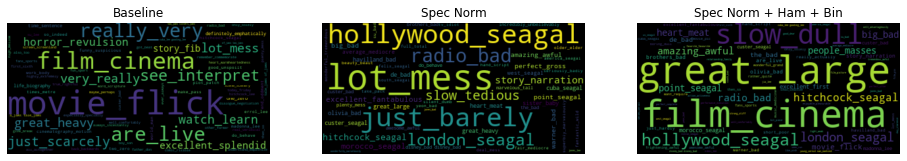

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16,8))
axs[0].imshow(regWord, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title("Baseline")
axs[1].imshow(snWord, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title("Spec Norm")
axs[2].imshow(binWord, interpolation='bilinear')
axs[2].axis('off')
axs[2].set_title("Spec Norm + Ham + Bin")
plt.show()

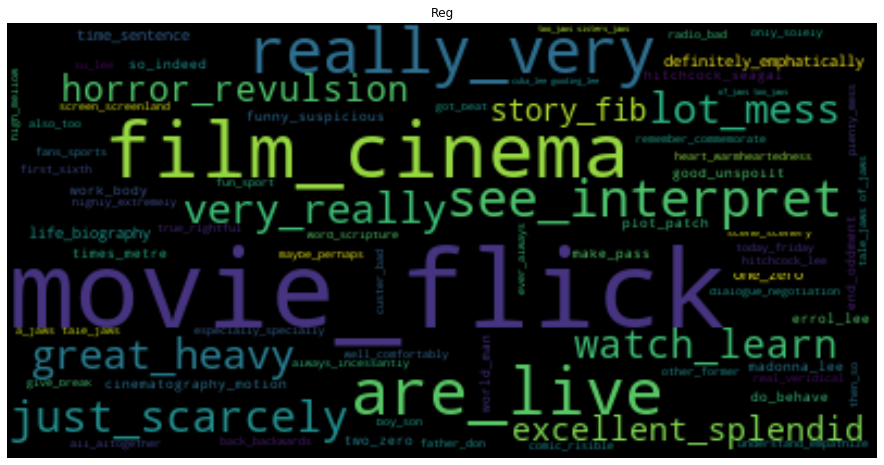

In [16]:
fig = plt.figure(figsize=(16,8))
plt.imshow(regWord, interpolation='bilinear')
plt.title("Reg")
plt.axis('off')
plt.show()

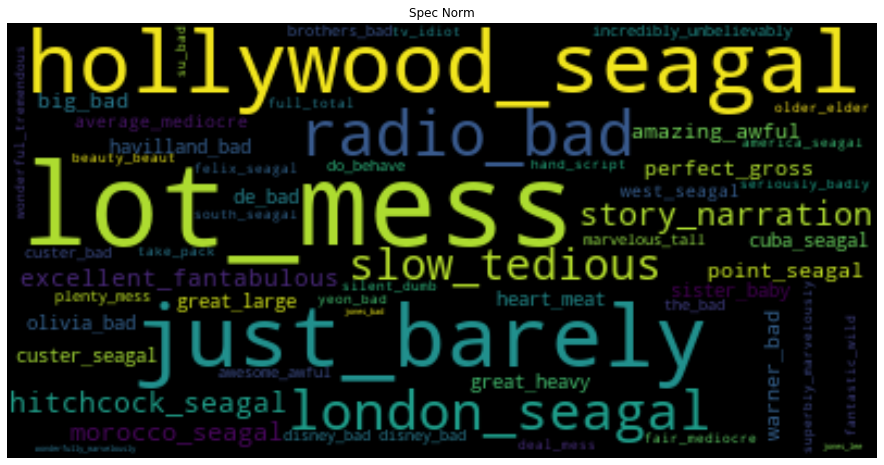

In [17]:
fig = plt.figure(figsize=(16,8))
plt.imshow(snWord, interpolation='bilinear')
plt.title("Spec Norm")
plt.axis('off')
plt.show()

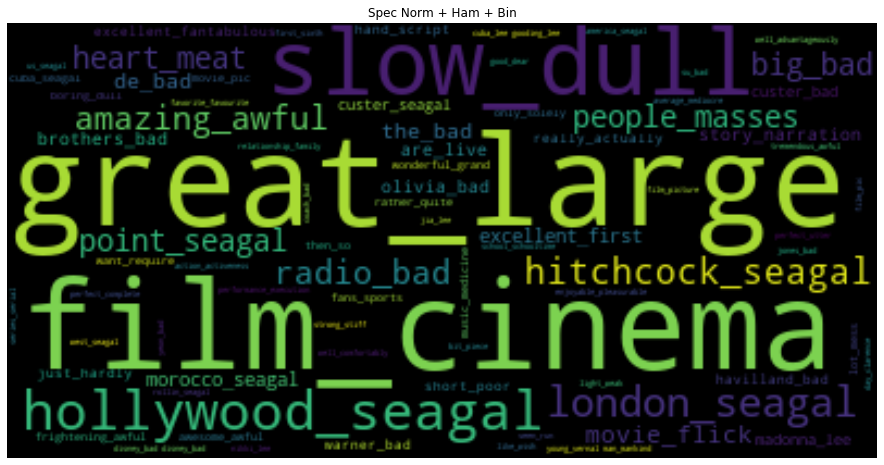

In [18]:
fig = plt.figure(figsize=(16,8))
plt.imshow(binWord, interpolation='bilinear')
plt.title("Spec Norm + Ham + Bin")
plt.axis('off')
plt.show()

### Results and Analysis: Example Analysis

Lastly for our results we leave with an example of an adversarial example generated for all 3 networks. Any substitions are notated "original/replacement". In the example below we can see that both the baseline and spectral norm model are fooled by a single replacement. The spectral norm + binary hamming loss requires several, some of which that are semantic breaking, substitions to generate an adversarial example. For example 3 words in a row, the, final, and seconds are all replaced with "minutes". This sentence now makes 0 sense.

**Baseline**

The film begins with a jaded professor haranguing his class because the students have the audacity to not be as incredibly brilliant as he is! You can tell very quickly that this man is a total cynic--finding the value in practically nothing but sticking to his own inner sense of self-importance. Additionally, he seems tired and bored with the monotony of life.Later in the film, he walks into a bank robbery and manages to annoy the robbers so much that one of them shoots him in the head. Oddly, this is only half-way through the film and what followed was a very bizarre narration of the final seconds of his life. This is when the film becomes exciting because the style of the narration is just like one of this literature professor's novels--one that is intelligently written and says things the way we wish we could all say them.See this weird film--it's **amazingly/astonishingly** compelling and not like anything I've ever seen before.

**Spectral Norm**

The film begins with a jaded professor haranguing his class because the students have the audacity to not be as incredibly **brilliant/bright** as he is! You can tell very quickly that this man is a total cynic--finding the value in practically nothing but sticking to his own inner sense of self-importance. Additionally, he seems tired and bored with the monotony of life.Later in the film, he walks into a bank robbery and manages to annoy the robbers so much that one of them shoots him in the head. Oddly, this is only half-way through the film and what followed was a very bizarre narration of the final seconds of his life. This is when the film becomes exciting because the style of the narration is just like one of this literature professor's novels--one that is intelligently written and says things the way we wish we could all say them.See this weird film--it's amazingly compelling and not like anything I've ever seen before.

**Spec Norm + Binary**

The film begins with a jaded professor haranguing his class because the students have the audacity to not be as incredibly **brilliant/vivid** as he is! You can tell **very/really** quickly that this man is a total cynic--finding the value in practically nothing but sticking to his own **inner/internal** sense of self-importance. Additionally, he seems **tired/old** and bored with the monotony of life. Later in the film, he walks into a **bank/coin** robbery and manages to **annoy/bother** the robbers so much that one of them shoots him in the head. Oddly, this is only half-way through the film and what followed was a very bizarre narration of **the/minutes** **final/minutes** **seconds/minutes** of his **life/biography**. This is when the film becomes exciting because the style of the **narration/yarn** is **just/barely** like **one/zero** of this literature professor's novels--**one/zero** that is intelligently written and says things the way we wish we could all say them.See this weird film--it's amazingly compelling and not like anything I've ever seen before.

## Future Work

In this work we only tested on a single simple model, on a small set of data. We also only focused on a single attack, PWWS, which claimed to have made small modifications to the input to adhere to the adversarial property that humans cannot tell the difference after the attack. In addition to this, while our metrics are acceptable by current standards, the adversarial quality of the attacks generated by PWWS after our defense are "questionable". A better evaluation scheme would be to get humans to review generated adversarial attacks and approve their validity. This way we could get a more realistic measure of our defense accuracy. In closing this work could be extended to character models, larger models, and use a more extension (and expensive) evaluation scheme. 

## Conclusions

While a minor loss in accuracy is suffered on clean examples, our method is much more robust to adversarial attacks generated via PWWS. We believe if humans were to read through the generated adversarial examples, the attack success rate would in reality be quite a bit lower. The hamming word embedding modification + binary normalization loss also improves upon spectral normalization results, as well as the naive cosine similarity based hamming loss.


## References

[1] Yoon Kim. Convolutional neural networks for sentence classification. CoRR,
abs/1408.5882, 2014.

[2] Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y.
Ng, and Christopher Potts. Learning word vectors for sentiment analysis. In
Proceedings of the 49th Annual Meeting of the Association for Computational
Linguistics: Human Language Technologies, pages 142–150, Portland, Oregon,
USA, June 2011. Association for Computational Linguistics.

[3] Takeru Miyato, Toshiki Kataoka, Masanori Koyama, and Yuichi Yoshida.
Spectral normalization for generative adversarial networks. CoRR,
abs/1802.05957, 2018.

[4] Shuhuai Ren, Yihe Deng, Kun He, and Wanxiang Che. Generating natural
language adversarial examples through probability weighted word saliency.
In Proceedings of the 57th Annual Meeting of the Association for Computational
Linguistics, pages 1085–1097, Florence, Italy, July 2019. Association
for Computational Linguistics.

[5] Xiang Xu, Xiaofang Wang, and Kris M. Kitani. Error correction maximization
for deep image hashing. CoRR, abs/1808.01942, 2018.

In [1]:
import os
from read_files import split_imdb_files, split_yahoo_files, split_agnews_files
from read_files import split_imdb_files, split_yahoo_files, split_agnews_files
from word_level_process import word_process, get_tokenizer
from char_level_process import char_process
# from neural_networks import word_cnn, char_cnn, bd_lstm, lstm
import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, Flatten, Reshape
from SpectralNormalizationKeras import DenseSN, ConvSN2D
import sklearn
import tensorflow as tf
import argparse
from config import config
from sklearn.utils import shuffle
from adversarial_tools import ForwardGradWrapper, adversarial_paraphrase
from unbuffered import Unbuffered
import sys
import time
import numpy as np
import operator
import re
import scipy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math
from keras import losses
#import pdb

# Need to run
# python -m spacy download en_core_web_sm
# Then shutdown and restart notebook
# nltk.download("wordnet")

tf_config = tf.ConfigProto(allow_soft_placement=True)
tf_config.gpu_options.allow_growth = True
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
K.set_session(tf.Session(config=tf_config))

Using TensorFlow backend.
/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/local-scratch4/kevin/anacond

In [5]:
from config import config

def get_embedding_matrix(dataset, num_words, embedding_dims):
    # global num_words, embedding_matrix, word_index
    global embedding_matrix, word_index
    word_index = get_tokenizer(dataset).word_index
    print('Preparing embedding matrix.')
    # num_words = min(num_words, len(word_index))
    embedding_matrix = np.zeros((num_words + 1, embedding_dims))
    for word, i in word_index.items():
        if i > num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, word_index

def word_cnn(dataset, use_glove=False, sn=True, binary=False):
    filters = 250
    kernel_size = 3
    hidden_dims = 250

    max_len = config.word_max_len[dataset]
    num_classes = config.num_classes[dataset]
    loss = config.loss[dataset]
    activation = config.activation[dataset]
    embedding_dims = config.wordCNN_embedding_dims[dataset]
    num_words = config.num_words[dataset]
#     print(num_words)

    print('Build word_cnn model...')
    model = Sequential()

    if use_glove:
        file_path = r'./glove.6B.{}d.txt'.format(str(embedding_dims))
#         pdb.set_trace()
#         get_embedding_index(file_path)
        embedding_matrix, word_index = get_embedding_matrix(dataset, num_words, embedding_dims)
        model.add(Embedding(  # Layer 0, Start
            input_dim=num_words + 1,  # Size to dictionary, has to be input + 1
            output_dim=embedding_dims,  # Dimensions to generate
            weights=[embedding_matrix],  # Initialize word weights
            input_length=max_len,
            name="embedding_layer",
            trainable=False))
    else:
        # embedding_dims => 50
        word_index = get_tokenizer(dataset).word_index
        model.add(Embedding(num_words, embedding_dims, input_length=max_len))  
    model.add(Dropout(0.2))

    
    if sn:
    ##  with SN  ##
        model.add(Reshape((-1, 400, 50)))
        model.add(ConvSN2D(filters, (1, kernel_size), strides=1, padding='valid', activation='relu'))
        model.add(Reshape((398, 250)))
        model.add(GlobalMaxPooling1D())
        model.add(DenseSN(hidden_dims))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(DenseSN(num_classes))
        model.add(Activation(activation))
    else:
    
    ##  without SN  ##
        model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(hidden_dims))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(Dense(num_classes))
        model.add(Activation(activation))
    
    # get threshold
    ## compute Gilbert–Varshamov Bound ##
    def _check_(L, M, d):
        left = 0
        for i in range(0, d):
            left = left + scipy.special.binom(L,i)
        tmp = float(pow(2, int(L))) / left
        return (tmp>M)

    def gvbound(L,M,tight=False):
        d = 1
        while (_check_(L, M, d)): d += 1
        if not tight: d -= 1
        print('Distance for %d classes with %d bits (GV bound): %d' %(M,L,d))
        return d

    ## compute Hamming Bound ##
    def check(L, M, d):
        right = float(pow(2, int(L))) / float(M)
        x = math.floor(float(d - 1) / 2.0)
        left = 0
        for i in range(0, x+1):
            left = left + scipy.special.binom(L,i)
        return (left <= right)
    
    def hammingbound(L,M,tight=False):
        d = 0
        while (check(L, M, d)): d += 1
        if not tight: d -= 1
        print('Distance for %d classes with %d bits (Hamming bound): %d' %(M,L,d))
        return d
    
    embedding_dims = config.wordCNN_embedding_dims[dataset]
    num_words = config.num_words[dataset]
    ham_bound = hammingbound(embedding_dims, num_words)
    gv_bound = gvbound(embedding_dims,num_words)
    bound = ham_bound

    def custom_loss_wrapper(y_true, y_pred):
        # ce-loss
        xent_loss = losses.binary_crossentropy(y_true, y_pred)
        # quantization loss
        embedding_output = model.layers[0].output
        Bbatch = tf.sign(embedding_output)
        quan_l = K.mean(keras.losses.mean_absolute_error(Bbatch,embedding_output))
        # ecoc loss
        centers = model.layers[0].weights[0]
        centers_binary = tf.sign(centers)
#         norm_centers = tf.math.l2_normalize(centers, axis=1)
#         prod = tf.matmul(norm_centers, tf.transpose(norm_centers)) #5000 x 5000
        prod = tf.matmul(centers, tf.transpose(centers)) #5000 x 5000
        ham_dist = K.mean(0.5 * (embedding_dims - prod))
#         marg_loss = K.mean(prod)
#         tmp = K.maximum(0.0, ham_dist - bound)
#         non_zero = K.sum(K.cast(tmp > 0, dtype='float32'))
#         marg_loss = K.sum(tmp) * 1.0/(non_zero+1.0)

        #tmp2 = K.maximum(0.0, gv_bound - ham_dist)
        #non_zero2 = K.sum(K.cast(tmp2 > 0, dtype='float32'))
        #marg_loss2 = K.sum(tmp2) * 1.0/(non_zero2+1.0)
        
        return  xent_loss - ham_dist + 0.1*quan_l
    
    def quan_loss(y_true, y_pred):
        embedding_output = model.layers[0].output
        Bbatch = tf.sign(embedding_output)
        quan_l = K.mean(keras.losses.mean_absolute_error(Bbatch,embedding_output))
        return  quan_l

    def ecoc_loss(y_true, y_pred):
        # ecoc loss
        centers = model.layers[0].weights[0]
        centers_binary = tf.sign(centers)
        norm_centers = tf.math.l2_normalize(centers, axis=1)
        prod = tf.matmul(norm_centers, tf.transpose(norm_centers)) #5000 x 5000
        ham_dist = 0.5 * (embedding_dims - prod)
#         marg_loss = K.mean(prod)
        tmp = K.maximum(0.0, bound - ham_dist)
        non_zero = K.sum(K.cast(tmp > 0, dtype='float32'))
        marg_loss = K.sum(tmp) * 1.0/(non_zero+1.0)
        #tmp = K.maximum(0.0, ham_dist - bound)
        #non_zero = K.sum(K.cast(tmp > 0, dtype='float32'))
        #marg_loss = K.sum(tmp) * 1.0/(non_zero+1.0)
        return  marg_loss

    if binary:
        model.compile(loss=custom_loss_wrapper,
                      optimizer='adam',
                      metrics=['accuracy',quan_loss,ecoc_loss])
    else:
        model.compile(loss=loss,
                      optimizer='adam',
                      metrics=['accuracy'])

    if sn:
        model_path = r'./fool_result/backup/word_cnn.dat_15epoch_sn'
        if binary:
            model_path = r'./runs/imdb/word_cnn.dat_20epoch_binary_sn'
    else:
        model_path = r'./fool_result/backup/word_cnn.dat_15epoch'
        
    #model_path = r'./runs/{}/{}.dat_15epoch_sn'.format(dataset, args.model)
    model.load_weights(model_path)
    return model, model.layers[0].get_weights()

### Training Procedure

Following the paper we will train and test on an NLP dataset. Due to time constraints we will only focus on the IMDB sentiment classification dataset as it is the smallest. We also only train the word level CNN model featured below. 

In [12]:
def train_text_classifier(model = "word_cnn", dataset = "imdb", level = "word",
                         use_glove=False, sn=False, binary=False):
    x_train = y_train = x_test = y_test = None
    if dataset == 'imdb':
        train_texts, train_labels, test_texts, test_labels = split_imdb_files()
        if level == 'word':
            x_train, y_train, x_test, y_test = word_process(train_texts, train_labels, test_texts, test_labels, dataset)
        elif level == 'char':
            x_train, y_train, x_test, y_test = char_process(train_texts, train_labels, test_texts, test_labels, dataset)
    elif dataset == 'agnews':
        train_texts, train_labels, test_texts, test_labels = split_agnews_files()
        if level == 'word':
            x_train, y_train, x_test, y_test = word_process(train_texts, train_labels, test_texts, test_labels, dataset)
        elif level == 'char':
            x_train, y_train, x_test, y_test = char_process(train_texts, train_labels, test_texts, test_labels, dataset)
    elif dataset == 'yahoo':
        train_texts, train_labels, test_texts, test_labels = split_yahoo_files()
        if level == 'word':
            x_train, y_train, x_test, y_test = word_process(train_texts, train_labels, test_texts, test_labels, dataset)
        elif level == 'char':
            x_train, y_train, x_test, y_test = char_process(train_texts, train_labels, test_texts, test_labels, dataset)
    x_train, y_train = shuffle(x_train, y_train, random_state=0)

    # Take a look at the shapes
    print('dataset:', dataset, '; model:', model, '; level:', level)
    print('X_train:', x_train.shape)
    print('y_train:', y_train.shape)
    print('X_test:', x_test.shape)
    print('y_test:', y_test.shape)

    log_dir = r'./logs/{}/{}_notebook/'.format(dataset, model)
    tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)

    model_path = r'./runs/{}/{}_notebook.dat_sn'.format(dataset, model)
    batch_size = epochs = None
#     assert model[:4] == level

    if model == "word_cnn":
        model = word_cnn(dataset, use_glove, sn, binary)
        batch_size = config.wordCNN_batch_size[dataset]
        epochs = config.wordCNN_epochs[dataset]
       
    print(model.summary())
    print('Train...')
    print('batch_size: ', batch_size, "; epochs: ", epochs)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2,
              shuffle=True,
              callbacks=[tb_callback])
    scores = model.evaluate(x_test, y_test)
    print('test_loss: %f, accuracy: %f' % (scores[0], scores[1]))
    print('Saving model weights...')
    model.save_weights(model_path)



In [5]:
train_text_classifier()

Processing IMDB dataset
dataset: imdb ; model: word_cnn ; level: word
X_train: (25000, 400)
y_train: (25000, 2)
X_test: (25000, 400)
y_test: (25000, 2)
Build word_cnn model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)          (No

In [3]:
sys.stdout = Unbuffered(sys.stdout)
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
K.set_session(tf.Session(config=tfconfig))
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

def write_origin_input_texts(origin_input_texts_path, test_texts, test_samples_cap=None):
    if test_samples_cap is None:
        test_samples_cap = len(test_texts)
    with open(origin_input_texts_path, 'a') as f:
        for i in range(test_samples_cap):
            f.write(test_texts[i] + '\n')


def fool_text_classifier(clean_samples_cap = 200, dataset="imdb", 
                         level = "word", argsModel = "word_cnn", model_type="sn", binary=False,
                        hamming = False, cosMod = False):
    print('clean_samples_cap:', clean_samples_cap)

    # get tokenizer
    tokenizer = get_tokenizer(dataset)

    # Read data set
    x_test = y_test = None
    test_texts = None
    if dataset == 'imdb':
        train_texts, train_labels, test_texts, test_labels = split_imdb_files()
        if level == 'word':
            x_train, y_train, x_test, y_test = word_process(train_texts, train_labels, test_texts, test_labels, dataset)
        elif level == 'char':
            x_train, y_train, x_test, y_test = char_process(train_texts, train_labels, test_texts, test_labels, dataset)
    elif dataset == 'agnews':
        train_texts, train_labels, test_texts, test_labels = split_agnews_files()
        if level == 'word':
            x_train, y_train, x_test, y_test = word_process(train_texts, train_labels, test_texts, test_labels, dataset)
        elif level == 'char':
            x_train, y_train, x_test, y_test = char_process(train_texts, train_labels, test_texts, test_labels, dataset)
    elif dataset == 'yahoo':
        train_texts, train_labels, test_texts, test_labels = split_yahoo_files()
        if level == 'word':
            x_train, y_train, x_test, y_test = word_process(train_texts, train_labels, test_texts, test_labels, dataset)
        elif level == 'char':
            x_train, y_train, x_test, y_test = char_process(train_texts, train_labels, test_texts, test_labels, dataset)
    
    # Write clean examples into a txt file
    clean_texts_path = r'./fool_result/{}/clean_{}_15epoch_sn.txt'.format(dataset, str(clean_samples_cap))
    if not os.path.isfile(clean_texts_path):
        write_origin_input_texts(clean_texts_path, test_texts)

    # Select the model and load the trained weights
    model = None
    if argsModel == "word_cnn":
        if model_type == "sn":
            model, embMat = word_cnn(dataset)
        else:
            model, embMat = word_cnn(dataset, sn=False)
    
    if model_type == "sn":
        model_path = r'./fool_result/backup/{}.dat_15epoch_{}'.format(argsModel, model_type)
        if binary:
            if hamming:
                model_path = r'./runs/imdb/word_cnn.dat_ecoc_v6'
            if cosMod:
                model_path = r'./runs/imdb/word_cnn.dat_cosine_0.1ratio_binary'
            if (hamming == False) and (cosMod == False):
                model_path  = r'./runs/imdb/word_cnn.dat_15epoch_best_binary_sn'          
    else:
        model_path = r'./fool_result/backup/{}.dat_15epoch'.format(argsModel, model_type)
            
    #model_path = r'./runs/{}/{}.dat_15epoch_sn'.format(dataset, args.model)
    model.load_weights(model_path)
    print('model path:', model_path)
    #model.compile()
    # evaluate classification accuracy of model on clean samples
    scores_origin = model.evaluate(x_test[:clean_samples_cap], y_test[:clean_samples_cap])
    print('clean samples origin test_loss: %f, accuracy: %f' % (scores_origin[0], scores_origin[1]))
    all_scores_origin = model.evaluate(x_test, y_test)
    print('all origin test_loss: %f, accuracy: %f' % (all_scores_origin[0], all_scores_origin[1]))
    
    grad_guide = ForwardGradWrapper(model)
    classes_prediction = grad_guide.predict_classes(x_test[: clean_samples_cap])

    print('Crafting adversarial examples...')
    successful_perturbations = 0
    failed_perturbations = 0
    sub_rate_list = []
    NE_rate_list = []

    start_cpu = time.clock()
    adv_text_path = r'./fool_result/{}/{}/adv_{}_15epoch.txt'.format(dataset, argsModel, str(clean_samples_cap))
    change_tuple_path = r'./fool_result/{}/{}/change_tuple_{}_15epoch.txt'.format(dataset, argsModel, str(clean_samples_cap))
    file_1 = open(adv_text_path, "a")
    file_2 = open(change_tuple_path, "a")
    for index, text in enumerate(test_texts[: clean_samples_cap]):
        sub_rate = 0
        NE_rate = 0
        #if np.argmax(y_test[index]) == classes_prediction[index]:
        # If the ground_true label is the same as the predicted label
        adv_doc, adv_y, sub_rate, NE_rate, change_tuple_list = adversarial_paraphrase(input_text=text,
                                                                                          true_y=np.argmax(y_test[index]),
                                                                                          grad_guide=grad_guide,
                                                                                          tokenizer=tokenizer,
                                                                                          dataset=dataset,
                                                                                          level=level)
        if adv_y != np.argmax(y_test[index]):
            successful_perturbations += 1
            print('{}. Successful example crafted.'.format(index))
        else:
            failed_perturbations += 1
            print('{}. Failure.'.format(index))

        text = adv_doc
        sub_rate_list.append(sub_rate)
        NE_rate_list.append(NE_rate)
        file_2.write(str(index) + str(change_tuple_list) + '\n')
        file_1.write(text + " sub_rate: " + str(sub_rate) + "; NE_rate: " + str(NE_rate) + "\n")

    end_cpu = time.clock()
    print('CPU second:', end_cpu - start_cpu)
    mean_sub_rate = sum(sub_rate_list) / len(sub_rate_list)
    mean_NE_rate = sum(NE_rate_list) / len(NE_rate_list)
    print('mean substitution rate:', mean_sub_rate)
    print('mean NE rate:', mean_NE_rate)
    file_1.close()
    file_2.close()
    print("Failed Examples: {}".format(failed_perturbations))

In [3]:
# Baseline Model
fool_text_classifier(model_type="reg")

clean_samples_cap: 200
Processing IMDB dataset
Build word_cnn model...
model path: ./fool_result/backup/word_cnn.dat_15epoch
200/200 [==============================] - ETA:  - 0s 848us/step
clean samples origin test_loss: 0.453442, accuracy: 0.905000
25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 53us/step
all origin test_loss: 0.667997, accuracy: 0.873360
Crafting adversarial examples...


/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


use 4 substitution; use 0 NE
Prob before:  0.9999964 . Prob after:  0.04041684 . Prob shift:  0.9595796
0. Successful example crafted.
use 46 substitution; use 4 NE
Prob before:  1.0 . Prob after:  0.97520995 . Prob shift:  0.024790049
1. Failure.
use 1 substitution; use 0 NE
Prob before:  0.058819517 . Prob after:  0.005277878 . Prob shift:  0.053541638
2. Successful example crafted.
use 3 substitution; use 0 NE
Prob before:  0.99999976 . Prob after:  0.46801013 . Prob shift:  0.53198963
3. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.9909512 . Prob after:  0.02099374 . Prob shift:  0.9699575
4. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.0023648469 . Prob after:  1.0809337e-06 . Prob shift:  0.0023637658
5. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.9999571 . Prob after:  0.013925651 . Prob shift:  0.9860314
6. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.99983156 . Prob

Prob before:  1.0 . Prob after:  0.4231567 . Prob shift:  0.57684326
121. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.0021594914 . Prob after:  4.451353e-06 . Prob shift:  0.0021550402
122. Successful example crafted.
use 5 substitution; use 0 NE
Prob before:  1.0 . Prob after:  0.29303756 . Prob shift:  0.70696247
123. Successful example crafted.
use 20 substitution; use 0 NE
Prob before:  0.9999994 . Prob after:  0.42728022 . Prob shift:  0.5727192
124. Successful example crafted.
use 13 substitution; use 0 NE
Prob before:  0.9999999 . Prob after:  0.44805077 . Prob shift:  0.55194914
125. Successful example crafted.
use 52 substitution; use 5 NE
Prob before:  0.9999982 . Prob after:  0.9939594 . Prob shift:  0.006038785
126. Failure.
use 56 substitution; use 5 NE
Prob before:  1.0 . Prob after:  0.9926958 . Prob shift:  0.0073041916
127. Failure.
use 4 substitution; use 0 NE
Prob before:  1.0 . Prob after:  0.31934187 . Prob shift:  0.6806581
128. Succes

/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [14]:
# Baseline Model + SN
fool_text_classifier(model_type="sn")

clean_samples_cap: 200
Processing IMDB dataset
Build word_cnn model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Distance for 5000 classes with 50 bits (Hamming bound): 26
Distance for 5000 classes with 50 bits (GV bound): 13
model path: ./fool_result/backup/word_cnn.dat_15epoch_sn
200/200 [==============================] - ETA:  - 2s 9ms/step
clean samples origin test_loss: 0.289439, accuracy: 0.895000
25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 81us/step
all origin test_loss: 0.343144, accuracy: 0.851240
Crafting adversar

/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


use 7 substitution; use 1 NE
Prob before:  0.9227084 . Prob after:  0.46576768 . Prob shift:  0.4569407
0. Successful example crafted.
use 7 substitution; use 2 NE
Prob before:  0.9670988 . Prob after:  0.48654208 . Prob shift:  0.4805567
1. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.070512734 . Prob after:  0.048530526 . Prob shift:  0.021982208
2. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.76436305 . Prob after:  0.482183 . Prob shift:  0.28218004
3. Successful example crafted.
use 4 substitution; use 1 NE
Prob before:  0.96956944 . Prob after:  0.37088782 . Prob shift:  0.5986816
4. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.54016936 . Prob after:  0.18408923 . Prob shift:  0.3560801
5. Successful example crafted.
use 8 substitution; use 1 NE
Prob before:  0.9214516 . Prob after:  0.41671044 . Prob shift:  0.5047412
6. Successful example crafted.
use 6 substitution; use 0 NE
Prob before:  0.963

Prob before:  0.83285797 . Prob after:  0.44491267 . Prob shift:  0.3879453
121. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.26912642 . Prob after:  0.22094215 . Prob shift:  0.04818426
122. Successful example crafted.
use 3 substitution; use 0 NE
Prob before:  0.97595406 . Prob after:  0.4894858 . Prob shift:  0.48646826
123. Successful example crafted.
use 33 substitution; use 5 NE
Prob before:  0.95669055 . Prob after:  0.49826536 . Prob shift:  0.4584252
124. Successful example crafted.
use 29 substitution; use 5 NE
Prob before:  0.92827433 . Prob after:  0.48709258 . Prob shift:  0.44118175
125. Successful example crafted.
use 52 substitution; use 5 NE
Prob before:  0.9222174 . Prob after:  0.7643663 . Prob shift:  0.1578511
126. Failure.
use 4 substitution; use 0 NE
Prob before:  0.98201513 . Prob after:  0.4490803 . Prob shift:  0.53293484
127. Successful example crafted.
use 6 substitution; use 2 NE
Prob before:  0.98625284 . Prob after:  0.49752313

/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [4]:
fool_text_classifier(model_type="sn", binary=True, cosMod=True)

clean_samples_cap: 200
Processing IMDB dataset
Build word_cnn model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Distance for 5000 classes with 50 bits (Hamming bound): 26
Distance for 5000 classes with 50 bits (GV bound): 13
model path: ./runs/imdb/word_cnn.dat_cosine_0.1ratio_binary
200/200 [==============================] - ETA:  - 2s 9ms/step
clean samples origin test_loss: 0.317479, accuracy: 0.880000
25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 75us/step
all origin test_loss: 0.372194, accuracy: 0.843020
Crafting adversarial examples...


/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


use 40 substitution; use 5 NE
Prob before:  0.9431079 . Prob after:  0.46059254 . Prob shift:  0.48251536
0. Successful example crafted.
use 46 substitution; use 4 NE
Prob before:  0.93931866 . Prob after:  0.591051 . Prob shift:  0.34826767
1. Failure.
use 1 substitution; use 0 NE
Prob before:  0.14368764 . Prob after:  0.10581525 . Prob shift:  0.03787239
2. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.6919015 . Prob after:  0.41981432 . Prob shift:  0.2720872
3. Successful example crafted.
use 2 substitution; use 0 NE
Prob before:  0.898345 . Prob after:  0.41762835 . Prob shift:  0.48071665
4. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.4491381 . Prob after:  0.30479285 . Prob shift:  0.14434525
5. Successful example crafted.
use 20 substitution; use 2 NE
Prob before:  0.8317333 . Prob after:  0.44450805 . Prob shift:  0.38722524
6. Successful example crafted.
use 31 substitution; use 3 NE
Prob before:  0.9075879 . Prob after

Prob before:  0.97753155 . Prob after:  0.8462197 . Prob shift:  0.13131183
61. Failure.
use 113 substitution; use 7 NE
Prob before:  0.9012656 . Prob after:  0.5404542 . Prob shift:  0.3608114
62. Failure.
use 4 substitution; use 0 NE
Prob before:  0.72642785 . Prob after:  0.49372685 . Prob shift:  0.232701
63. Successful example crafted.
use 2 substitution; use 0 NE
Prob before:  0.8475851 . Prob after:  0.29593512 . Prob shift:  0.5516499
64. Successful example crafted.
use 41 substitution; use 4 NE
Prob before:  0.8641971 . Prob after:  0.4791832 . Prob shift:  0.38501388
65. Successful example crafted.
use 4 substitution; use 0 NE
Prob before:  0.8473495 . Prob after:  0.45254996 . Prob shift:  0.39479956
66. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.19396411 . Prob after:  0.17595498 . Prob shift:  0.018009126
67. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.5742815 . Prob after:  0.32850555 . Prob shift:  0.24577597
68.

122. Successful example crafted.
use 8 substitution; use 0 NE
Prob before:  0.9638545 . Prob after:  0.49217495 . Prob shift:  0.47167954
123. Successful example crafted.
use 2 substitution; use 0 NE
Prob before:  0.84030277 . Prob after:  0.39188197 . Prob shift:  0.4484208
124. Successful example crafted.
use 22 substitution; use 2 NE
Prob before:  0.89553326 . Prob after:  0.49357477 . Prob shift:  0.4019585
125. Successful example crafted.
use 52 substitution; use 5 NE
Prob before:  0.8345547 . Prob after:  0.65183645 . Prob shift:  0.18271822
126. Failure.
use 4 substitution; use 0 NE
Prob before:  0.9641613 . Prob after:  0.3796264 . Prob shift:  0.5845349
127. Successful example crafted.
use 4 substitution; use 1 NE
Prob before:  0.9804072 . Prob after:  0.38431174 . Prob shift:  0.59609544
128. Successful example crafted.
use 109 substitution; use 4 NE
Prob before:  0.93379843 . Prob after:  0.8205765 . Prob shift:  0.11322194
129. Failure.
use 51 substitution; use 1 NE
Prob be

Prob before:  0.90313554 . Prob after:  0.45724162 . Prob shift:  0.4458939
184. Successful example crafted.
use 61 substitution; use 7 NE
Prob before:  0.9546698 . Prob after:  0.47840774 . Prob shift:  0.47626203
185. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.4523421 . Prob after:  0.23451945 . Prob shift:  0.21782264
186. Successful example crafted.
use 6 substitution; use 1 NE
Prob before:  0.7146341 . Prob after:  0.48209232 . Prob shift:  0.2325418
187. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.5853445 . Prob after:  0.37026602 . Prob shift:  0.21507847
188. Successful example crafted.
use 5 substitution; use 0 NE
Prob before:  0.73419684 . Prob after:  0.4894128 . Prob shift:  0.24478403
189. Successful example crafted.
use 95 substitution; use 6 NE
Prob before:  0.9026304 . Prob after:  0.4932868 . Prob shift:  0.4093436
190. Successful example crafted.
use 27 substitution; use 3 NE
Prob before:  0.968895 . Prob afte

/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [6]:
# SN + Binary + Ham
fool_text_classifier(model_type="sn", binary=True, hamming=True)

clean_samples_cap: 200
Processing IMDB dataset
Build word_cnn model...
Distance for 5000 classes with 50 bits (Hamming bound): 26
Distance for 5000 classes with 50 bits (GV bound): 13
model path: ./runs/imdb/word_cnn.dat_ecoc_v6
200/200 [==============================] - ETA:  - 0s 1ms/step
clean samples origin test_loss: 0.302437, accuracy: 0.885000
25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 86us/step
all origin test_loss: 0.355098, accuracy: 0.851740
Crafting adversarial examples...


/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


use 8 substitution; use 1 NE
Prob before:  0.89424413 . Prob after:  0.48391408 . Prob shift:  0.41033006
0. Successful example crafted.
use 46 substitution; use 4 NE
Prob before:  0.9049018 . Prob after:  0.63647133 . Prob shift:  0.26843047
1. Failure.
use 1 substitution; use 0 NE
Prob before:  0.09434451 . Prob after:  0.07638107 . Prob shift:  0.01796344
2. Successful example crafted.
use 62 substitution; use 1 NE
Prob before:  0.944809 . Prob after:  0.82573575 . Prob shift:  0.11907327
3. Failure.
use 2 substitution; use 1 NE
Prob before:  0.75506765 . Prob after:  0.40402162 . Prob shift:  0.35104603
4. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.52055186 . Prob after:  0.30446273 . Prob shift:  0.21608913
5. Successful example crafted.
use 5 substitution; use 0 NE
Prob before:  0.89547706 . Prob after:  0.44313872 . Prob shift:  0.45233834
6. Successful example crafted.
use 35 substitution; use 3 NE
Prob before:  0.9274104 . Prob after:  0.47431028 

use 13 substitution; use 1 NE
Prob before:  0.9780677 . Prob after:  0.49637285 . Prob shift:  0.48169485
123. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.6832039 . Prob after:  0.4658219 . Prob shift:  0.21738198
124. Successful example crafted.
use 1 substitution; use 0 NE
Prob before:  0.93613076 . Prob after:  0.4832005 . Prob shift:  0.45293027
125. Successful example crafted.
use 52 substitution; use 5 NE
Prob before:  0.9206418 . Prob after:  0.74960274 . Prob shift:  0.17103904
126. Failure.
use 34 substitution; use 2 NE
Prob before:  0.9758539 . Prob after:  0.4175848 . Prob shift:  0.55826914
127. Successful example crafted.
use 6 substitution; use 2 NE
Prob before:  0.9448544 . Prob after:  0.40598714 . Prob shift:  0.53886724
128. Successful example crafted.
use 109 substitution; use 4 NE
Prob before:  0.9542347 . Prob after:  0.897911 . Prob shift:  0.056323707
129. Failure.
use 51 substitution; use 1 NE
Prob before:  0.9562604 . Prob after:  0

/local-scratch4/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [6]:
def get_tokenizer(dataset):
    texts = None
    if dataset == 'imdb':
        texts, _ = read_imdb_files('train')
    elif dataset == 'yahoo':
        texts, _, _ = read_yahoo_files()
    elif dataset == 'agnews':
        texts, _, _ = read_agnews_files('train')
    # first 12500 are postive review, second 12500 are negative review
#     print(config.num_words[dataset])
    tokenizer = Tokenizer(num_words=config.num_words[dataset])
    tokenizer.fit_on_texts(texts)
    return tokenizer

In [10]:
from config import config
def getMu_WordCloud(useSN, binary=False):
    snModel, snEmbs = word_cnn("imdb", use_glove=False, sn=useSN, binary=binary)
    t = get_tokenizer("imdb")
    embMat = snEmbs[0]
    sorted_d = sorted(t.word_counts.items(), key=operator.itemgetter(1))
    topWords = sorted_d[-5000:][::-1]

    wordToDex = {}
    for wordDex, wordTup in enumerate(topWords):
        wordToDex[wordTup[0]] = wordDex + 1
        
    if useSN:
        fName = "./fool_result/backup/change_tuple_200_15epoch_sn.txt"
        if binary:
            fName = "./fool_result/backup/change_tuple_200_ecoc_v6.txt"
    else:
        fName = "./fool_result/backup/change_tuple_200_15epoch.txt"

    replaceSims = []
    replacePairs = []
    with open(fName, 'r') as f:
        lines = f.readlines()
        for lineDex, line in enumerate(lines):
            if lineDex <= 9:
                line = line[1:]
            else:
                line = line[2:]

            searchObj = re.findall( r"\(([0-9]*), '([A-Za-z]*)', SubstitutionCandidate\(token_position=[0-9]*, similarity_rank=[0-9]*, original_token=[A-Za-z]*, candidate_word='([A-Za-z]*)'\), [0-9]*.[0-9]*, '[A-Z]*'\)", line)
            tups = []

            for m in searchObj:
                if m[-1] == ",":
                    tups.append(m[:-1])
                else:
                    tups.append(m)

            searchObj = re.findall( r"\(([0-9]*), '([A-Za-z]*)', SubstitutionCandidate\(token_position=[0-9]*, similarity_rank=None, original_token=[A-Za-z]*, candidate_word='([A-Za-z]*)'\), [0-9]*.[0-9]*, '[A-Z]*'\)", line)
            for m in searchObj:
                if m[-1] == ",":
                    tups.append(m[:-1])
                else:
                    tups.append(m)

            for tup in tups:
                orgWord = tup[1].lower()
                replace = tup[2].lower()
                replacePairs.append(orgWord + "_" + replace)
                if orgWord in wordToDex and replace in wordToDex:
                    orgDex = wordToDex[orgWord]
                    repDex = wordToDex[replace]
                    sim = scipy.spatial.distance.cosine(embMat[orgDex, :], embMat[repDex, :])
                    replaceSims.append(sim)

    replaceSims = np.array(replaceSims)
    mu = replaceSims.mean()
    std = replaceSims.std()
    
    wCloudRep = " ".join(replacePairs)
    wordcloud = WordCloud().generate(wCloudRep)
    
    return mu, std, wordcloud

In [11]:
regMu, regStd, regWord = getMu_WordCloud(useSN=False, binary=False)
snMu, snStd, snWord = getMu_WordCloud(useSN=True, binary=False)
binMu, binStd, binWord = getMu_WordCloud(useSN=True, binary=True)

Build word_cnn model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Distance for 5000 classes with 50 bits (Hamming bound): 26
Distance for 5000 classes with 50 bits (GV bound): 13
Build word_cnn model...
Distance for 5000 classes with 50 bits (Hamming bound): 26
Distance for 5000 classes with 50 bits (GV bound): 13
Build word_cnn model...
Distance for 5000 classes with 50 bits (Hamming bound): 26
Distance for 5000 classes with 50 bits (GV bound): 13


In [12]:
print("Reg Mu: {} SN Mu: {} Bin Mu: {}".format(regMu, snMu, binMu))

Reg Mu: 0.9859629060666278 SN Mu: 0.9276315625598257 Bin Mu: 0.8457451819662662


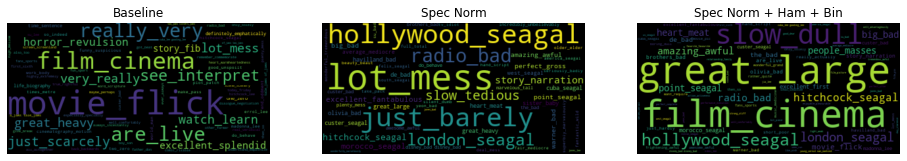

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16,8))
axs[0].imshow(regWord, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title("Baseline")
axs[1].imshow(snWord, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title("Spec Norm")
axs[2].imshow(binWord, interpolation='bilinear')
axs[2].axis('off')
axs[2].set_title("Spec Norm + Ham + Bin")
plt.show()

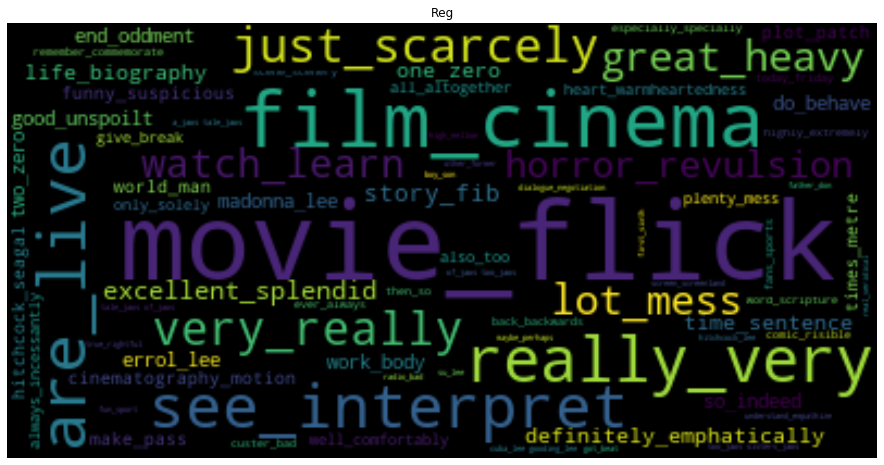

In [29]:
fig = plt.figure(figsize=(16,8))
plt.imshow(regWord, interpolation='bilinear')
plt.title("Reg")
plt.axis('off')
plt.show()

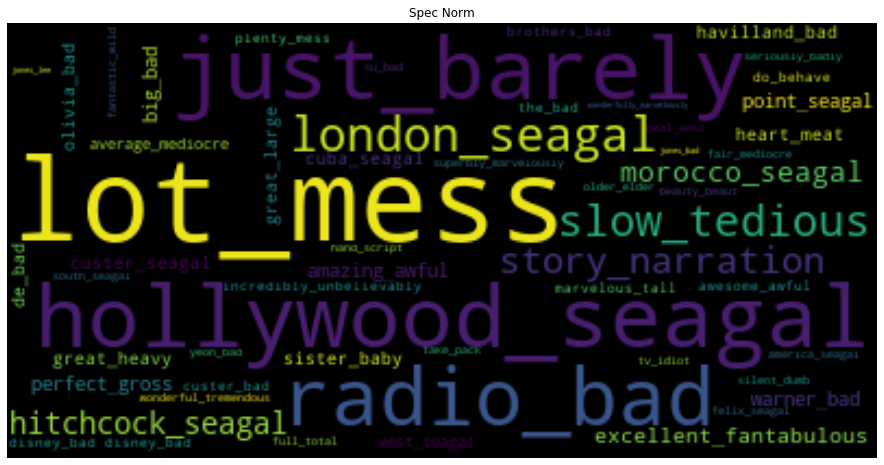

In [31]:
fig = plt.figure(figsize=(16,8))
plt.imshow(snWord, interpolation='bilinear')
plt.title("Spec Norm")
plt.axis('off')
plt.show()

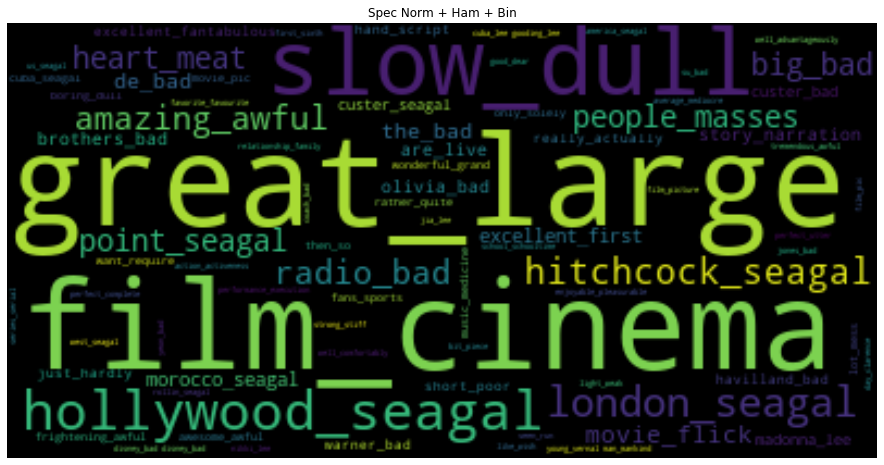

In [14]:
fig = plt.figure(figsize=(16,8))
plt.imshow(binWord, interpolation='bilinear')
plt.title("Spec Norm + Ham + Bin")
plt.axis('off')
plt.show()